# Question 1:  Data Normalizaton (4 marks)

In [8]:
#Importing necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tensorflow import keras
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_class_weight

#Data preprocessing and modeling related functions
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator


#Cross-validation and evaluation related functions
from sklearn.model_selection import KFold


#Data preprocessing and modeling related functions
# from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from keras.optimizers import SGD
from keras.utils import to_categorical


AttributeError: module 'tensorflow.compat.v2' has no attribute '__internal__'

In [3]:
# Load the CIFAR-10 dataset
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Exploring the dataset
print("Training set shape:", x_train.shape)
print("Test set shape:", x_test.shape)

Training set shape: (50000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)


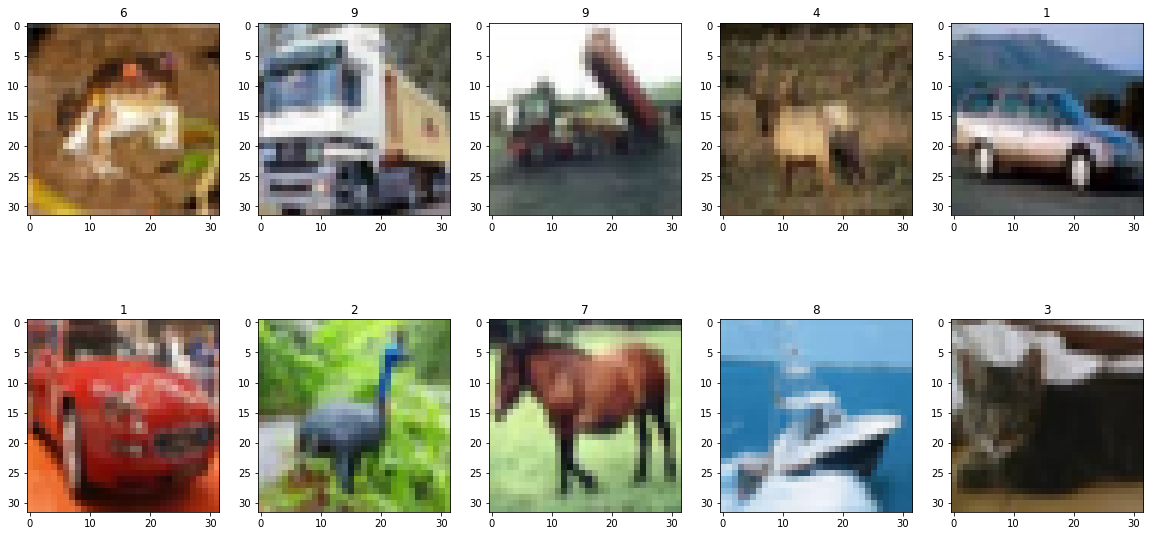

In [4]:
# display images from dataset
images = range(0,10)
classes = list(np.unique(y_train))
plt.figure(figsize=(20,10))
for i in images:
        plt.subplot(2,5,1 + i).set_title(classes[y_train[i][0]])
        plt.imshow(x_train[i].reshape(32,32,3))

In [5]:
# Reshape the arrays to have only 2 dimensions
x_train = x_train.reshape(50000, 32 * 32 * 3)
x_test  = x_test.reshape (10000, 32 * 32 * 3)

print("Training set shape:", x_train.shape)
print("Test set shape:", x_test.shape)

Training set shape: (50000, 3072)
Test set shape: (10000, 3072)


In [6]:
## Splitting "training" dataset further into train,test datasets 
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')

In [7]:
from sklearn import model_selection, preprocessing, metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## method (1) MinMax - is preferred when working with TensorFlow
# minmax_scaler = preprocessing.MinMaxScaler()
# x_train_ms= minmax_scaler.fit_transform(x_train)
# x_valid_ms= minmax_scaler.fit_transform(x_valid)
# x_test_ms= minmax_scaler.fit_transform(x_test)
x_train_ms= x_train/255
x_valid_ms= x_valid/255
x_text_ms = x_test/255

print(f"The minimum and maximum values after min-max scaling are {np.min(x_train_ms)} and {np.max(x_train_ms)} respectively.")

## method (2) Standard Normalisation - after MinMax
# standard_scaler = preprocessing.StandardScaler()
# x_train_ss= standard_scaler.fit_transform(x_train)
# x_valid_ss= standard_scaler.fit_transform(x_valid)
# x_test_ss= standard_scaler.fit_transform(x_test)
mean = np.mean(x_train_ms, axis=0)
std = np.std(x_train_ms, axis=0)
x_train_ss = (x_train_ms - mean) / std
x_valid_ss = (x_valid_ms - mean )/ std
x_test_ss = (x_text_ms - mean) / std

print(f"The minimum and maximum values after min-max scaling and normalisation are {np.min(x_train_ss)} and {np.max(x_train_ss)} respectively.")
    
print(mean)
print(std)

The minimum and maximum values after min-max scaling are 0.0 and 1.0 respectively.
The minimum and maximum values after min-max scaling and normalisation are -2.2122802734375 and 2.6272494792938232 respectively.
[0.5128192  0.53400755 0.5202159  ... 0.49730805 0.4942249  0.449564  ]
[0.2881187  0.28597057 0.31555888 ... 0.25485855 0.2457989  0.25905165]


In [8]:
# By converting the target variables to one-hot format, we can ensure that they are compatible with 
# the output layer of the MLP model, which expects the target variables to be represented as a vector 
# of binary values. 

y_train_1hot = np_utils.to_categorical(y_train, 10)
y_valid_1hot = np_utils.to_categorical(y_valid, 10) 
y_test_1hot  = np_utils.to_categorical(y_test , 10)

In [9]:
# Create disctionary to keep track of accuracy of the models
model_summary={}

# Question 2:  Implementing a Multi-Layer Perceptron for CIFAR-10 Classification (10 marks)

### (1.1) MLP with one hidden layer consisting of 128 neurons,adam 
    -Optimizer: Adam
    -Loss: Cross Entropy
    -Hidden Layers: 1
    -Activation Layer: (ReLU, softmax)

In [10]:

# Define the model architecture
model = keras.Sequential([
    # Input Layer
    keras.layers.Dense(512, activation='relu', input_shape=(32*32*3,)),
    
    # Hidden Layers
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    
    # Output Layer
    keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model using mini-batch learning
batch_size = 64
epochs = 40
patience = 5
best_acc = 0
for epoch in range(epochs):
    for i in range(0, len(x_train_ms), batch_size):
        batch_x, batch_y = x_train_ms[i:i+batch_size], y_train_1hot[i:i+batch_size]
        model.train_on_batch(batch_x, batch_y)
    
    # Evaluate the model on the validation set after each epoch
    val_loss, val_acc = model.evaluate(x_valid_ms, y_valid_1hot)
    print('Epoch %d: validation accuracy=%f' % (epoch+1, val_acc))
    
    # Check if the validation accuracy has improved
    if val_acc > best_acc:
        best_acc = val_acc
        patience = 0
    else:
        patience += 1
        print("patience =",patience)
        
    # Stop training if the validation accuracy does not improve after a certain number of epochs
    if patience == 5:
        break
        
# Evaluate final model on test set
test_pred = model.predict(x_text_ms)
test_accuracy = accuracy_score(np.argmax(y_test_1hot, axis=1), np.argmax(test_pred, axis=1))

model_summary["(1.1) MLP with one hidden layer consisting of 128 neurons,adam"] = round(test_accuracy,2)
model_summary

313/313 [==============================] - 1s 2ms/step - loss: 1.8690 - accuracy: 0.3045
Epoch 1: validation accuracy=0.304500
313/313 [==============================] - 1s 2ms/step - loss: 1.7664 - accuracy: 0.3570
Epoch 2: validation accuracy=0.357000
313/313 [==============================] - 1s 2ms/step - loss: 1.6881 - accuracy: 0.3927
Epoch 3: validation accuracy=0.392700
313/313 [==============================] - 1s 2ms/step - loss: 1.6417 - accuracy: 0.4036
Epoch 4: validation accuracy=0.403600
313/313 [==============================] - 1s 2ms/step - loss: 1.5999 - accuracy: 0.4237
Epoch 5: validation accuracy=0.423700
313/313 [==============================] - 1s 3ms/step - loss: 1.5641 - accuracy: 0.4398
Epoch 6: validation accuracy=0.439800
313/313 [==============================] - 1s 2ms/step - loss: 1.5574 - accuracy: 0.4422
Epoch 7: validation accuracy=0.442200
313/313 [==============================] - 1s 2ms/step - loss: 1.5406 - accuracy: 0.4537
Epoch 8: validation ac

{'(1.1) MLP with one hidden layer consisting of 128 neurons,adam': 0.48}

### (1.2) MLP with one hidden layer consisting of 128 neurons, sgd
    -Optimizer: SGD
    -Loss: Cross Entropy
    -Hidden Layers: 1
    -Activation Layer: (ReLU, softmax)

In [11]:

# Define the model architecture
model = keras.Sequential([
    # Input Layer
    keras.layers.Dense(512, activation='relu', input_shape=(32*32*3,)),
    
    # Hidden Layers
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    
    # Output Layer
    keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model using mini-batch learning
batch_size = 64
epochs = 40
patience = 5
best_acc = 0
for epoch in range(epochs):
    for i in range(0, len(x_train_ms), batch_size):
        batch_x, batch_y = x_train_ms[i:i+batch_size], y_train_1hot[i:i+batch_size]
        model.train_on_batch(batch_x, batch_y)
    
    # Evaluate the model on the validation set after each epoch
    val_loss, val_acc = model.evaluate(x_valid_ms, y_valid_1hot)
    print('Epoch %d: validation accuracy=%f' % (epoch+1, val_acc))
    
    # Check if the validation accuracy has improved
    if val_acc > best_acc:
        best_acc = val_acc
        patience = 0
    else:
        patience += 1 
        print("patience =",patience)
        
    # Stop training if the validation accuracy does not improve after a certain number of epochs
    if patience == 5:
        break
        
# Evaluate final model on test set
test_pred = model.predict(x_text_ms)
test_accuracy = accuracy_score(np.argmax(y_test_1hot, axis=1), np.argmax(test_pred, axis=1))    
        
model_summary["(1.2) MLP with one hidden layer consisting of 128 neurons, sgd"] = round(test_accuracy,2)
model_summary

313/313 [==============================] - 1s 2ms/step - loss: 1.8372 - accuracy: 0.3487
Epoch 1: validation accuracy=0.348700
313/313 [==============================] - 1s 2ms/step - loss: 1.7409 - accuracy: 0.3852
Epoch 2: validation accuracy=0.385200
313/313 [==============================] - 1s 2ms/step - loss: 1.6918 - accuracy: 0.3940
Epoch 3: validation accuracy=0.394000
313/313 [==============================] - 1s 2ms/step - loss: 1.6476 - accuracy: 0.4109
Epoch 4: validation accuracy=0.410900
313/313 [==============================] - 1s 2ms/step - loss: 1.6185 - accuracy: 0.4203
Epoch 5: validation accuracy=0.420300
313/313 [==============================] - 1s 2ms/step - loss: 1.5919 - accuracy: 0.4279
Epoch 6: validation accuracy=0.427900
313/313 [==============================] - 1s 2ms/step - loss: 1.5761 - accuracy: 0.4357
Epoch 7: validation accuracy=0.435700
313/313 [==============================] - 1s 2ms/step - loss: 1.5517 - accuracy: 0.4435
Epoch 8: validation ac

{'(1.1) MLP with one hidden layer consisting of 128 neurons,adam': 0.48,
 '(1.2) MLP with one hidden layer consisting of 128 neurons, sgd': 0.51}

### (2.1) MLP with one hidden layer consisting of 256 neurons,adam

In [12]:

# Define the model architecture
model = keras.Sequential([
    # Input Layer
    keras.layers.Dense(512, activation='relu', input_shape=(32*32*3,)),
    
    # Hidden Layers
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.2),
    
    # Output Layer
    keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model using mini-batch learning
batch_size = 64
epochs = 40
patience = 5
best_acc = 0
for epoch in range(epochs):
    for i in range(0, len(x_train_ms), batch_size):
        batch_x, batch_y = x_train_ms[i:i+batch_size], y_train_1hot[i:i+batch_size]
        model.train_on_batch(batch_x, batch_y)
    
    # Evaluate the model on the validation set after each epoch
    val_loss, val_acc = model.evaluate(x_valid_ms, y_valid_1hot)
    print('Epoch %d: validation accuracy=%f' % (epoch+1, val_acc))
    
    # Check if the validation accuracy has improved
    if val_acc > best_acc:
        best_acc = val_acc
        patience = 0
    else:
        patience += 1 
        print("patience =",patience)
        
    # Stop training if the validation accuracy does not improve after a certain number of epochs
    if patience == 5:
        break

        
# Evaluate final model on test set
test_pred = model.predict(x_text_ms)
test_accuracy = accuracy_score(np.argmax(y_test_1hot, axis=1), np.argmax(test_pred, axis=1))    
        
model_summary["(2.1) MLP with one hidden layer consisting of 256 neurons,adam"] = round(test_accuracy,2)
model_summary

313/313 [==============================] - 1s 2ms/step - loss: 1.7817 - accuracy: 0.3457
Epoch 1: validation accuracy=0.345700
313/313 [==============================] - 1s 2ms/step - loss: 1.7009 - accuracy: 0.3772
Epoch 2: validation accuracy=0.377200
313/313 [==============================] - 1s 2ms/step - loss: 1.6356 - accuracy: 0.4107
Epoch 3: validation accuracy=0.410700
313/313 [==============================] - 1s 2ms/step - loss: 1.5967 - accuracy: 0.4281
Epoch 4: validation accuracy=0.428100
313/313 [==============================] - 1s 2ms/step - loss: 1.5988 - accuracy: 0.4313
Epoch 5: validation accuracy=0.431300
313/313 [==============================] - 1s 2ms/step - loss: 1.5771 - accuracy: 0.4359
Epoch 6: validation accuracy=0.435900
313/313 [==============================] - 1s 2ms/step - loss: 1.5518 - accuracy: 0.4484
Epoch 7: validation accuracy=0.448400
313/313 [==============================] - 1s 2ms/step - loss: 1.5470 - accuracy: 0.4524
Epoch 8: validation ac

{'(1.1) MLP with one hidden layer consisting of 128 neurons,adam': 0.48,
 '(1.2) MLP with one hidden layer consisting of 128 neurons, sgd': 0.51,
 '(2.1) MLP with one hidden layer consisting of 256 neurons,adam': 0.47}

### (2.2) MLP with one hidden layer consisting of 256 neurons,sgd
    -Optimizer: SGD
    -Loss: Cross Entropy
    -Hidden Layers: 1
    -Activation Layer: (ReLU, softmax)

In [13]:

# Define the model architecture
model = keras.Sequential([
    # Input Layer
    keras.layers.Dense(512, activation='relu', input_shape=(32*32*3,)),
    
    # Hidden Layers
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.2),
    
    # Output Layer
    keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model using mini-batch learning
batch_size = 64
epochs = 40
patience = 5
best_acc = 0
for epoch in range(epochs):
    for i in range(0, len(x_train_ms), batch_size):
        batch_x, batch_y = x_train_ms[i:i+batch_size], y_train_1hot[i:i+batch_size]
        model.train_on_batch(batch_x, batch_y)
    
    # Evaluate the model on the validation set after each epoch
    val_loss, val_acc = model.evaluate(x_valid_ms, y_valid_1hot)
    print('Epoch %d: validation accuracy=%f' % (epoch+1, val_acc))
    
    # Check if the validation accuracy has improved
    if val_acc > best_acc:
        best_acc = val_acc
        patience = 0
    else:
        patience += 1 
        print("patience =",patience)
        
    # Stop training if the validation accuracy does not improve after a certain number of epochs
    if patience == 5:
        break
        
# Evaluate final model on test set
test_pred = model.predict(x_text_ms)
test_accuracy = accuracy_score(np.argmax(y_test_1hot, axis=1), np.argmax(test_pred, axis=1))    

model_summary["(2.2) MLP with one hidden layer consisting of 256 neurons,sgd"] = round(test_accuracy,2)
model_summary

313/313 [==============================] - 1s 2ms/step - loss: 1.8210 - accuracy: 0.3520
Epoch 1: validation accuracy=0.352000
313/313 [==============================] - 1s 2ms/step - loss: 1.7367 - accuracy: 0.3872
Epoch 2: validation accuracy=0.387200
313/313 [==============================] - 1s 2ms/step - loss: 1.6831 - accuracy: 0.4067
Epoch 3: validation accuracy=0.406700
313/313 [==============================] - 1s 3ms/step - loss: 1.6465 - accuracy: 0.4160
Epoch 4: validation accuracy=0.416000
313/313 [==============================] - 1s 3ms/step - loss: 1.6150 - accuracy: 0.4270
Epoch 5: validation accuracy=0.427000
313/313 [==============================] - 1s 2ms/step - loss: 1.5925 - accuracy: 0.4337
Epoch 6: validation accuracy=0.433700
313/313 [==============================] - 1s 2ms/step - loss: 1.5680 - accuracy: 0.4444
Epoch 7: validation accuracy=0.444400
313/313 [==============================] - 1s 2ms/step - loss: 1.5484 - accuracy: 0.4500
Epoch 8: validation ac

{'(1.1) MLP with one hidden layer consisting of 128 neurons,adam': 0.48,
 '(1.2) MLP with one hidden layer consisting of 128 neurons, sgd': 0.51,
 '(2.1) MLP with one hidden layer consisting of 256 neurons,adam': 0.47,
 '(2.2) MLP with one hidden layer consisting of 256 neurons,sgd': 0.53}

### (3.1) MLP with two hidden layer consisting of 256 ,128 neurons, relu

In [14]:

# Define the model architecture
model = keras.Sequential([
    # Input Layer
    keras.layers.Dense(512, activation='relu', input_shape=(32*32*3,)),
    
    # Hidden Layers
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.2),
    
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    
    # Output Layer
    keras.layers.Dense(10, activation='softmax')  # Change activation function to softmax
])

# Compile the model with Adam optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using mini-batch learning
batch_size = 64
epochs = 40
patience = 5
best_acc = 0

for epoch in range(epochs):
    for i in range(0, len(x_train_ms), batch_size):
        batch_x, batch_y = x_train_ms[i:i+batch_size], y_train_1hot[i:i+batch_size]  # Use y_train_1hot instead of y_train
        model.train_on_batch(batch_x, batch_y)
    
    # Evaluate the model on the validation set after each epoch
    val_loss, val_acc = model.evaluate(x_valid_ms, y_valid_1hot)  # Use y_valid_1hot instead of y_valid
    print('Epoch %d: validation accuracy=%f' % (epoch+1, val_acc))
    
    # Check if the validation accuracy has improved
    if val_acc > best_acc:
        best_acc = val_acc
        patience = 0
    else:
        patience += 1 
        print("patience =",patience)
            
    # Stop training if the validation accuracy does not improve after a certain number of epochs
    if patience == 5:
        break

        
# Evaluate final model on test set
test_pred = model.predict(x_text_ms)
test_accuracy = accuracy_score(np.argmax(y_test_1hot, axis=1), np.argmax(test_pred, axis=1))    

model_summary["(3.1) MLP with two hidden layer consisting of 256,128 neurons,relu"]=round(test_accuracy,2)
model_summary


313/313 [==============================] - 1s 2ms/step - loss: 1.8156 - accuracy: 0.3385
Epoch 1: validation accuracy=0.338500
313/313 [==============================] - 1s 2ms/step - loss: 1.7413 - accuracy: 0.3677
Epoch 2: validation accuracy=0.367700
313/313 [==============================] - 1s 2ms/step - loss: 1.6874 - accuracy: 0.3848
Epoch 3: validation accuracy=0.384800
313/313 [==============================] - 1s 3ms/step - loss: 1.6626 - accuracy: 0.3988
Epoch 4: validation accuracy=0.398800
313/313 [==============================] - 1s 2ms/step - loss: 1.6354 - accuracy: 0.4075
Epoch 5: validation accuracy=0.407500
313/313 [==============================] - 1s 2ms/step - loss: 1.5720 - accuracy: 0.4319
Epoch 6: validation accuracy=0.431900
313/313 [==============================] - 1s 2ms/step - loss: 1.5710 - accuracy: 0.4328
Epoch 7: validation accuracy=0.432800
313/313 [==============================] - 1s 2ms/step - loss: 1.5539 - accuracy: 0.4410
Epoch 8: validation ac

{'(1.1) MLP with one hidden layer consisting of 128 neurons,adam': 0.48,
 '(1.2) MLP with one hidden layer consisting of 128 neurons, sgd': 0.51,
 '(2.1) MLP with one hidden layer consisting of 256 neurons,adam': 0.47,
 '(2.2) MLP with one hidden layer consisting of 256 neurons,sgd': 0.53,
 '(3.1) MLP with two hidden layer consisting of 256,128 neurons,relu': 0.48}

### Testing 1: MLP with two hidden layer consisting of 256,128 neurons,tanh

In [15]:

# Define the model architecture
model = keras.Sequential([
    # Input Layer
    keras.layers.Dense(512, activation='tanh', input_shape=(32*32*3,)),
    
    # Hidden Layers
    keras.layers.Dense(256, activation='tanh'),
    keras.layers.Dropout(0.2),
    
    keras.layers.Dense(128, activation='tanh'),
    keras.layers.Dropout(0.2),
    
    # Output Layer
    keras.layers.Dense(10, activation='softmax')  # Change activation function to softmax
])

# Compile the model with Adam optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using mini-batch learning
batch_size = 64
epochs = 40
patience = 5
best_acc = 0

for epoch in range(epochs):
    for i in range(0, len(x_train_ms), batch_size):
        batch_x, batch_y = x_train_ms[i:i+batch_size], y_train_1hot[i:i+batch_size]  # Use y_train_1hot instead of y_train
        model.train_on_batch(batch_x, batch_y)
    
    # Evaluate the model on the validation set after each epoch
    val_loss, val_acc = model.evaluate(x_valid_ms, y_valid_1hot)  # Use y_valid_1hot instead of y_valid
    print('Epoch %d: validation accuracy=%f' % (epoch+1, val_acc))
    
    # Check if the validation accuracy has improved
    if val_acc > best_acc:
        best_acc = val_acc
        patience = 0
    else:
        patience += 1 
        print("patience =",patience)
            
    # Stop training if the validation accuracy does not improve after a certain number of epochs
    if patience == 5:
        break

        
# Evaluate final model on test set
test_pred = model.predict(x_text_ms)
test_accuracy = accuracy_score(np.argmax(y_test_1hot, axis=1), np.argmax(test_pred, axis=1))    


model_summary["Testing 1: MLP with two hidden layer consisting of 256,128 neurons,tanh"]=round(test_accuracy,2)
model_summary



313/313 [==============================] - 1s 2ms/step - loss: 1.9238 - accuracy: 0.2922
Epoch 1: validation accuracy=0.292200
313/313 [==============================] - 1s 2ms/step - loss: 1.8747 - accuracy: 0.3093
Epoch 2: validation accuracy=0.309300
313/313 [==============================] - 1s 3ms/step - loss: 1.8406 - accuracy: 0.3334
Epoch 3: validation accuracy=0.333400
313/313 [==============================] - 1s 3ms/step - loss: 1.8168 - accuracy: 0.3419
Epoch 4: validation accuracy=0.341900
313/313 [==============================] - 1s 2ms/step - loss: 1.8442 - accuracy: 0.3172
Epoch 5: validation accuracy=0.317200
patience = 1
313/313 [==============================] - 1s 3ms/step - loss: 1.8159 - accuracy: 0.3368
Epoch 6: validation accuracy=0.336800
patience = 2
313/313 [==============================] - 1s 2ms/step - loss: 1.7685 - accuracy: 0.3566
Epoch 7: validation accuracy=0.356600
313/313 [==============================] - 1s 2ms/step - loss: 1.7960 - accuracy: 0.3

{'(1.1) MLP with one hidden layer consisting of 128 neurons,adam': 0.48,
 '(1.2) MLP with one hidden layer consisting of 128 neurons, sgd': 0.51,
 '(2.1) MLP with one hidden layer consisting of 256 neurons,adam': 0.47,
 '(2.2) MLP with one hidden layer consisting of 256 neurons,sgd': 0.53,
 '(3.1) MLP with two hidden layer consisting of 256,128 neurons,relu': 0.48,
 'Testing 1: MLP with two hidden layer consisting of 256,128 neurons,tanh': 0.36}

### Testing 2: MLP with three hidden layer consisting of 256,128,64 neurons,tanh

In [16]:


# Define the model architecture
model = keras.Sequential([
    # Input Layer
    keras.layers.Dense(512, activation='tanh', input_shape=(32*32*3,)),
    
    # Hidden Layers
    keras.layers.Dense(256, activation='tanh'),
    keras.layers.Dropout(0.2),
    
    keras.layers.Dense(128, activation='tanh'),
    keras.layers.Dropout(0.2),
    
    keras.layers.Dense(64, activation='tanh'),
    keras.layers.Dropout(0.2),
    
    # Output Layer
    keras.layers.Dense(10, activation='softmax')  # Change activation function to softmax
])

# Compile the model with Adam optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using mini-batch learning
batch_size = 64
epochs = 40
patience = 5
best_acc = 0

for epoch in range(epochs):
    for i in range(0, len(x_train_ms), batch_size):
        batch_x, batch_y = x_train_ms[i:i+batch_size], y_train_1hot[i:i+batch_size]  # Use y_train_1hot instead of y_train
        model.train_on_batch(batch_x, batch_y)
    
    # Evaluate the model on the validation set after each epoch
    val_loss, val_acc = model.evaluate(x_valid_ms, y_valid_1hot)  # Use y_valid_1hot instead of y_valid
    print('Epoch %d: validation accuracy=%f' % (epoch+1, val_acc))
    
    # Check if the validation accuracy has improved
    if val_acc > best_acc:
        best_acc = val_acc
        patience = 0
    else:
        patience += 1 
        print("patience =",patience)
            
    # Stop training if the validation accuracy does not improve after a certain number of epochs
    if patience == 5:
        break


# Evaluate final model on test set
test_pred = model.predict(x_text_ms)
test_accuracy = accuracy_score(np.argmax(y_test_1hot, axis=1), np.argmax(test_pred, axis=1))    


model_summary["Testing 2: MLP with three hidden layer consisting of 256,128,64 neurons,tanh"]=round(test_accuracy,2)
model_summary



313/313 [==============================] - 1s 2ms/step - loss: 2.0142 - accuracy: 0.2404
Epoch 1: validation accuracy=0.240400
313/313 [==============================] - 1s 2ms/step - loss: 1.9507 - accuracy: 0.2610
Epoch 2: validation accuracy=0.261000
313/313 [==============================] - 1s 2ms/step - loss: 1.9248 - accuracy: 0.2789
Epoch 3: validation accuracy=0.278900
313/313 [==============================] - 1s 2ms/step - loss: 1.9199 - accuracy: 0.2821
Epoch 4: validation accuracy=0.282100
313/313 [==============================] - 1s 2ms/step - loss: 1.8942 - accuracy: 0.3005
Epoch 5: validation accuracy=0.300500
313/313 [==============================] - 1s 2ms/step - loss: 1.9201 - accuracy: 0.2902
Epoch 6: validation accuracy=0.290200
patience = 1
313/313 [==============================] - 1s 3ms/step - loss: 1.8839 - accuracy: 0.3098
Epoch 7: validation accuracy=0.309800
313/313 [==============================] - 1s 2ms/step - loss: 1.8806 - accuracy: 0.3033
Epoch 8: 

{'(1.1) MLP with one hidden layer consisting of 128 neurons,adam': 0.48,
 '(1.2) MLP with one hidden layer consisting of 128 neurons, sgd': 0.51,
 '(2.1) MLP with one hidden layer consisting of 256 neurons,adam': 0.47,
 '(2.2) MLP with one hidden layer consisting of 256 neurons,sgd': 0.53,
 '(3.1) MLP with two hidden layer consisting of 256,128 neurons,relu': 0.48,
 'Testing 1: MLP with two hidden layer consisting of 256,128 neurons,tanh': 0.36,
 'Testing 2: MLP with three hidden layer consisting of 256,128,64 neurons,tanh': 0.32}

### Testing 3:  MLP with three hidden layer consisting of 256,128,64 neurons,LeakyRelu

In [17]:
from tensorflow import keras
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np
from keras.utils import to_categorical

# Define the model architecture
model = keras.Sequential([
    # Input Layer
    keras.layers.Dense(512, activation='leaky_relu', input_shape=(32*32*3,)),
    
    # Hidden Layers
    keras.layers.Dense(256, activation='leaky_relu'),
    keras.layers.Dropout(0.2),
    
    keras.layers.Dense(128, activation='leaky_relu'),
    keras.layers.Dropout(0.2),
    
    keras.layers.Dense(64, activation='leaky_relu'),
    keras.layers.Dropout(0.2),
    
    # Output Layer
    keras.layers.Dense(10, activation='softmax')  # Change activation function to softmax
])

# Compile the model with Adam optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using mini-batch learning
batch_size = 64
epochs = 40
patience = 5
best_acc = 0

for epoch in range(epochs):
    for i in range(0, len(x_train_ms), batch_size):
        batch_x, batch_y = x_train_ms[i:i+batch_size], y_train_1hot[i:i+batch_size]  # Use y_train_1hot instead of y_train
        model.train_on_batch(batch_x, batch_y)
    
    # Evaluate the model on the validation set after each epoch
    val_loss, val_acc = model.evaluate(x_valid_ms, y_valid_1hot)  # Use y_valid_1hot instead of y_valid
    print('Epoch %d: validation accuracy=%f' % (epoch+1, val_acc))
    
    # Check if the validation accuracy has improved
    if val_acc > best_acc:
        best_acc = val_acc
        patience = 0
    else:
        patience += 1 
        print("patience =",patience)
            
    # Stop training if the validation accuracy does not improve after a certain number of epochs
    if patience == 5:
        break

        
        

# Evaluate final model on test set
test_pred = model.predict(x_text_ms)
test_accuracy = accuracy_score(np.argmax(y_test_1hot, axis=1), np.argmax(test_pred, axis=1))    

model_summary["Testing 3: MLP with three hidden layer consisting of 256,128,64 neurons,LeakyRelu"]=round(test_accuracy,2)
model_summary



313/313 [==============================] - 1s 2ms/step - loss: 1.8372 - accuracy: 0.3287
Epoch 1: validation accuracy=0.328700
313/313 [==============================] - 1s 2ms/step - loss: 1.7915 - accuracy: 0.3467
Epoch 2: validation accuracy=0.346700
313/313 [==============================] - 1s 2ms/step - loss: 1.7174 - accuracy: 0.3665
Epoch 3: validation accuracy=0.366500
313/313 [==============================] - 1s 3ms/step - loss: 1.6353 - accuracy: 0.4022
Epoch 4: validation accuracy=0.402200
313/313 [==============================] - 1s 3ms/step - loss: 1.6249 - accuracy: 0.4226
Epoch 5: validation accuracy=0.422600
313/313 [==============================] - 1s 2ms/step - loss: 1.5976 - accuracy: 0.4227
Epoch 6: validation accuracy=0.422700
313/313 [==============================] - 1s 2ms/step - loss: 1.5814 - accuracy: 0.4359
Epoch 7: validation accuracy=0.435900
313/313 [==============================] - 1s 2ms/step - loss: 1.5632 - accuracy: 0.4366
Epoch 8: validation ac

{'(1.1) MLP with one hidden layer consisting of 128 neurons,adam': 0.48,
 '(1.2) MLP with one hidden layer consisting of 128 neurons, sgd': 0.51,
 '(2.1) MLP with one hidden layer consisting of 256 neurons,adam': 0.47,
 '(2.2) MLP with one hidden layer consisting of 256 neurons,sgd': 0.53,
 '(3.1) MLP with two hidden layer consisting of 256,128 neurons,relu': 0.48,
 'Testing 1: MLP with two hidden layer consisting of 256,128 neurons,tanh': 0.36,
 'Testing 2: MLP with three hidden layer consisting of 256,128,64 neurons,tanh': 0.32,
 'Testing 3: MLP with three hidden layer consisting of 256,128,64 neurons,LeakyRelu': 0.5}

# Question 3

In [46]:
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

# Preprocessing

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = np_utils.to_categorical(y_train, 10)
y_test  = np_utils.to_categorical(y_test , 10)

x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')

x_train  /= 255
x_test   /= 255




transform_train = ImageDataGenerator(
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        rotation_range = 10,
        zoom_range=0.1,
        shear_range=0.1,
        vertical_flip=True,
        horizontal_flip=True)   # flip images horizontally

validation_train = ImageDataGenerator()


train_set = transform_train.flow(x_train[:40000], y_train[:40000], batch_size=32)
validation_set = validation_train.flow(x_train[40000:], y_train[40000:], batch_size=32)



In [ ]:
# !nbmerge Assignment2.ipynb.ipynb file_2.ipynb file_3.ipynb > merged_ouput.ipynb 

# Data Preparation

In [2]:
# Load the CIFAR-10 dataset
cifar10 = tf.keras.datasets.cifar10

# Preprocessing
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = to_categorical(y_train, 10)
y_test  = to_categorical(y_test , 10)

x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')

x_train  /= 255
x_test   /= 255


transform_train = ImageDataGenerator(
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        rotation_range = 10,
#         zoom_range=0.1,
#         shear_range=0.1,
#         vertical_flip=True,
        horizontal_flip=True)   # flip images horizontally

validation_train = ImageDataGenerator()


train_set = transform_train.flow(x_train[:40000], y_train[:40000], batch_size=32)
validation_set = validation_train.flow(x_train[40000:], y_train[40000:], batch_size=32)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


### [Question 3] Building a Convolutional Neural Network for CIFAR-10!

- Batch Size: 64
- Epochs: 50
- Padding: Same
- Kernel: 3*3
- (Convolution-BatchNormalisation-Relu-MaxPooling) x 2 
- Loss Function: Categorical Crossentropy
- Dropout: 0.25,0.25,0.5


###### `Padding: Same:` This means that the output spatial dimensions will be the same as the input spatial dimensions after applying the convolution operation. This is achieved by adding zeros around the borders of the input tensor so that the output spatial dimensions match the input spatial dimensions.
###### `Kernel: 3x3:` A kernel size of 3x3 is a standard choice for convolutional neural networks because it provides a good balance between capturing local patterns and not overfitting to the training data. Larger kernel sizes can capture more complex patterns but may lead to overfitting, while smaller kernel sizes may not capture enough information.
###### `(Convolution-BatchNormalisation-Relu-MaxPooling) x 2`: This sequence of layers is commonly used in convolutional neural networks because it allows the model to learn increasingly complex features while reducing overfitting.
###### `Batch normalization` normalize the activations to improve generalization
###### `ReLU activation functions` introduce non-linearity to the model
###### `Max pooling` layers downsample the spatial dimensions to reduce computational complexity and help the model learn spatial hierarchies.
###### `Loss Function: Categorical Crossentropy:` This loss function is commonly used for multi-class classification problems like image classification. It measures the difference between the predicted probabilities and the true labels by calculating the negative log likelihood of the true class. This encourages the model to output high probabilities for the correct classes and low probabilities for the incorrect classe
###### `Dropout` is a regularization technique that helps prevent overfitting by randomly setting some of the neurons to zero during training. By using a high dropout rate (0.25) and (0.5), it is likely to reduce overfitting and contribute to better performance.


In [7]:
## CNN Archeticure
def CNN():

    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]) )
    model.add(Activation('relu'))
    
    model.add(Conv2D(32,(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(32,(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(10))
    model.add(Activation('softmax'))

    
    
# Train model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

cnn = CNN()


cnn.fit(train_set, 
        epochs=50,
        batch_size=64,
        validation_data=validation_set, shuffle=True)

loss, acc = cnn.evaluate(x_test, y_test, verbose=1)
print('Test loss:', loss)
print('Test acc:', acc)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - accuracy: 0.3316 - loss: 1.9646 - val_accuracy: 0.5006 - val_loss: 1.4243
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.5072 - loss: 1.3822 - val_accuracy: 0.4684 - val_loss: 1.5537
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.5543 - loss: 1.2376 - val_accuracy: 0.6303 - val_loss: 1.0467
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.5847 - loss: 1.1615 - val_accuracy: 0.6687 - val_loss: 0.9481
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6136 - loss: 1.0898 - val_accuracy: 0.6705 - val_loss: 0.9473
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6289 - loss: 1.0544 - val_accuracy: 0.6607 - val_loss: 0.9691
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6370 - loss: 1.0241 - val_accuracy: 0.5878 - val_loss: 1.2684
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6450 -

## [Question 4]  Leveraging a Pretrained Model for CIFAR-10 

#### ResNet50 seems to be one of the better pretrained models, let's set it to take the shape of our input data of CIFAR-10 instead of the original settings.

In [ ]:
from keras.applications import VGG16, ResNet50, InceptionV3
from keras.layers import Flatten, Dense
from keras.models import Model

# Load ResNet50 pretrained model
# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

2024-03-15 12:26:52.228937: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 12:26:52.229073: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 12:26:52.402768: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### 1st Attempt:  freezing the pretrained layers and only train the top layer and not resize to 224x224
- Did not resize CIFAR to 224x224
- unfreeze only top layer
- Data Augmentation
- dropout = 0.5
- epoch =10
- batch_size =32

`Test acc: 0.337`

In [15]:
pretrained_model = tf.keras.applications.ResNet50(input_shape=(32, 32, 3),
                    include_top=False)

pretrained_model.trainable = False

model5_resnet50 = tf.keras.Sequential([
            pretrained_model,
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(rate=0.5), # add dropout layer with rate 0.5
            tf.keras.layers.Dense(10, activation='softmax')])

model5_resnet50.compile(optimizer='adam',loss = 'categorical_crossentropy',metrics=['accuracy'])
model5_resnet50.fit(train_set, 
        epochs=10,
        batch_size=32,
        validation_data=validation_set, shuffle=True)

loss, acc = model5_resnet50.evaluate(x_test, y_test, verbose=1)
print('Test loss:', loss)
print('Test acc:', acc)


Epoch 1/10
   8/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.1062 - loss: 3.0031

W0000 00:00:1710510215.475183     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1579 - loss: 2.3335

W0000 00:00:1710510253.492515     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 58s 35ms/step - accuracy: 0.1580 - loss: 2.3334 - val_accuracy: 0.2845 - val_loss: 1.9758
Epoch 2/10


W0000 00:00:1710510259.060521     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 0.2443 - loss: 2.0692 - val_accuracy: 0.2813 - val_loss: 1.9792
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 0.2604 - loss: 2.0226 - val_accuracy: 0.2896 - val_loss: 1.9479
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 0.2721 - loss: 2.0023 - val_accuracy: 0.3214 - val_loss: 1.8842
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 0.2743 - loss: 1.9952 - val_accuracy: 0.2921 - val_loss: 1.9096
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 0.2760 - loss: 1.9980 - val_accuracy: 0.2960 - val_loss: 1.9264
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 0.2798 - loss: 1.9764 - val_accuracy: 0.3306 - val_loss: 1.8778
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 0.2807 - loss: 1.9833 - val_accuracy: 0.3118 - val_loss: 1.9270
Epoch 9/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 0.2792 - loss: 1.97

W0000 00:00:1710510589.553399     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.3421 - loss: 1.8449
Test loss: 1.852772831916809
Test acc: 0.33730000257492065


W0000 00:00:1710510593.794515     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


#### It's obvious that the model is not performing well...

#### This is likely due to the fact that these pre-trained models have their weights trained on a different dataset (ImageNet) that might not be oprimal for our CIFAR-10.

#### By training the entire model together, we allow all layers to adapt to the new dataset and learn features that are more relevant for the CIFAR-10 classification task. This can lead to better performance compared to only training the top layer with frozen pre-trained layers.



### 2nd Attempt:  unfreeze all layers but still did not resize to 224x224
- Did not resize CIFAR to 224x224
- unfreeze all layers
- Data Augmentation
- batch normalisation
- dropout = 0.3
- epoch =100
- batch_size =16

`Test acc: 0.785`

In [3]:
pretrained_model = tf.keras.applications.ResNet50(input_shape=(32, 32, 3), include_top=False)
# Set trainable to True to update all layers during training
pretrained_model.trainable = True
model6_resnet50 = tf.keras.Sequential([
            pretrained_model,
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(rate=0.3), # add dropout layer with rate 0.3
            tf.keras.layers.Dense(10, activation='softmax')])
model6_resnet50.compile(optimizer='adam',loss = 'categorical_crossentropy',metrics=['accuracy'])
model6_resnet50.fit(train_set, 
        epochs=100,
        batch_size=16,
        validation_data=validation_set, shuffle=True)
loss, acc = model6_resnet50.evaluate(x_test, y_test, verbose=1)
print('Test loss:', loss)
print('Test acc:', acc)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   2/1250 ━━━━━━━━━━━━━━━━━━━━ 1:10 57ms/step - accuracy: 0.1719 - loss: 2.9569   

I0000 00:00:1710514213.025986     126 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710514213.125035     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3096 - loss: 2.2660

W0000 00:00:1710514252.689426     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 110s 36ms/step - accuracy: 0.3097 - loss: 2.2658 - val_accuracy: 0.4276 - val_loss: 2.4720
Epoch 2/100


W0000 00:00:1710514258.348643     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - accuracy: 0.4766 - loss: 1.7669 - val_accuracy: 0.4648 - val_loss: 12.6117
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - accuracy: 0.4778 - loss: 1.7521 - val_accuracy: 0.2231 - val_loss: 19.8326
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - accuracy: 0.4179 - loss: 1.8601 - val_accuracy: 0.3785 - val_loss: 8.1623
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - accuracy: 0.4168 - loss: 1.8642 - val_accuracy: 0.1402 - val_loss: 515.6135
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - accuracy: 0.3671 - loss: 1.9530 - val_accuracy: 0.3568 - val_loss: 27.5150
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - accuracy: 0.3837 - loss: 1.9206 - val_accuracy: 0.2772 - val_loss: 2.1623
Epoch 8/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - accuracy: 0.4041 - loss: 1.8376 - val_accuracy: 0.1740 - val_loss: 11.6895
Epoch 9/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - accuracy: 0.3947

W0000 00:00:1710518035.715236     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.7905 - loss: 3.8917


W0000 00:00:1710518040.034699     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Test loss: 4.087766647338867
Test acc: 0.7854999899864197


In [ ]:
from tensorflow.keras.layers.experimental import Resizing

# Load the CIFAR-10 dataset
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Preprocessing
y_train = to_categorical(y_train, 10)
y_test  = to_categorical(y_test , 10)

x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')

x_train  /= 255
x_test   /= 255

# Define the ResNet50 model with resizing layer
pretrained_model = tf.keras.applications.ResNet50(input_shape=(224, 224, 3),
                    include_top=False)

pretrained_model.trainable = False

resizing_layer = Resizing(size=(224, 224))

model5_resnet50 = tf.keras.Sequential([
            resizing_layer,
            pretrained_model,
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(rate=0.5), # add dropout layer with rate 0.5
            tf.keras.layers.Dense(10, activation='softmax')])

model5_resnet50.compile(optimizer='adam',loss = 'categorical_crossentropy',metrics=['accuracy'])

# Generate the training and validation sets
batch_size = 32
num_batches = x_train.shape[0] // batch_size

for i in range(num_batches):
    start = i * batch_size
    end = min((i + 1) * batch_size, x_train.shape[0])
    x_train[start:end] = tf.image.resize(x_train[start:end], [224, 224])

x_test = tf.image.resize(x_test, [224, 224])

transform_train = ImageDataGenerator(
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        rotation_range = 10,
#         zoom_range=0.1,
#         shear_range=0.1,
#         vertical_flip=True,
        horizontal_flip=True,
        rescale=1./255)

validation_train = ImageDataGenerator(rescale=1./255)

train_set = transform_train.flow(x_train[:40000], y_train[:40000], batch_size=batch_size)
validation_set = validation_train.flow(x_train[40000:], y_train[40000:], batch_size=batch_size)

model5_resnet50.fit(train_set, 
        epochs=10,
        batch_size=batch_size,
        validation_data=validation_set, shuffle=True)

loss, acc = model5_resnet50.evaluate(x_test, y_test, verbose=1)
print('Test loss:', loss)
print('Test acc:', acc)

### 3rd Attempt: resizing our CIFAR-10 to 224x224 and unfreeze all layers
- Resize CIFAR to 224x224 !!!
- unfreeze all layers
- Data Augmentation
- batch normalisation
- GlobalAveragePooling2D
- dropout = 0.4
- epoch =50
- batch_size =64
- EarlyStopping
- ModelCheckpoint

`Test acc: 0.898`

In [5]:
#Importing necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential, save_model,load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, LeakyReLU, ELU, Conv2D, MaxPooling2D, Input, GlobalAveragePooling2D, Resizing
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model


#Data preprocessing and modeling related functions
# from keras.utils import np_utils
from keras.utils import to_categorical


from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import ResNet50


In [7]:
# Load the CIFAR-10 dataset
cifar10 = tf.keras.datasets.cifar10

# Preprocessing
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = to_categorical(y_train, 10)
y_test  = to_categorical(y_test , 10)


x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')

x_train  /= 255
x_test   /= 255


transform_train = ImageDataGenerator(
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        rotation_range = 10,
#         zoom_range=0.1,
#         shear_range=0.1,
#         vertical_flip=True,
        horizontal_flip=True)   # flip images horizontally

validation_train = ImageDataGenerator()


train_set = transform_train.flow(x_train[:40000], y_train[:40000], batch_size=32)
validation_set = validation_train.flow(x_train[40000:], y_train[40000:], batch_size=32)

In [13]:
pretrained_model = ResNet50(input_shape=(224, 224, 3),
                    include_top=False)

pretrained_model.trainable = True

model = Sequential([
          Resizing(224, 224),  # Resize images to 224x224
            pretrained_model,
            BatchNormalization(),
            GlobalAveragePooling2D(),
            Dense(1024, activation='relu'),
            Dropout(0.4),
            Dense(10, activation='softmax', dtype='float32'),
        ])

# Compile the model with the same optimizer and loss function
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

# Define early stopping parameters
early_stopping_patience = 5 # Stop training if no improvement after 5 epochs
early_stopping_min_delta = 0.01 # Stop training if improvement is less than 0.01%

# Create EarlyStopping callback object
early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, min_delta=early_stopping_min_delta)

# Define where to save the best model based on validation accuracy
best_model_path = 'best_model.h5'

# Create ModelCheckpoint callback object
model_checkpoint = ModelCheckpoint(best_model_path + '.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# Continue training from the last saved model
model.fit(train_set, 
        epochs=50,
        batch_size=64,
        validation_data=validation_set, shuffle=True,callbacks=[early_stopping, model_checkpoint])

# Evaluate final model on test set
loss, acc = best_model.evaluate(x_test, y_test, verbose=1)

print('Test loss:', loss)
print('Test acc:', acc)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1710754107.922981     123 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.4787 - loss: 1.5068
Epoch 1: val_accuracy improved from -inf to 0.66380, saving model to best_model.h5.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 277s 163ms/step - accuracy: 0.4788 - loss: 1.5066 - val_accuracy: 0.6638 - val_loss: 1.0889
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.7365 - loss: 0.7618
Epoch 2: val_accuracy improved from 0.66380 to 0.73060, saving model to best_model.h5.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 214s 157ms/step - accuracy: 0.7365 - loss: 0.7618 - val_accuracy: 0.7306 - val_loss: 0.8598
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.7860 - loss: 0.6311
Epoch 3: val_accuracy did not improve from 0.73060
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 195s 156ms/step - accuracy: 0.7860 - loss: 0.6311 - val_accuracy: 0.7298 - val_loss: 0.9026
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8136 - loss: 0.5402
Epoch 4: val_accuracy did not improve from 0.73060

NameError: name 'best_model' is not defined

In [14]:
# Evaluate final model on test set
loss, acc = model.evaluate(x_test, y_test, verbose=1)

print('Test loss:', loss)
print('Test acc:', acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.8978 - loss: 0.3459
Test loss: 0.3532184064388275
Test acc: 0.8982999920845032


# Assignment Report

###### In Question 2: We experimented with several hidden layers, optimisers, combinations of neurons and arrived with our best model at "(2.2) MLP with one hidden layer consisting of 256 neurons,sgd'" with a test accuracy of 0.53. This demonstrates to us that more layers and neurons might not necessarily mean better performance as they might tend to overfit and lead to huge validation loss. This hints to us that experimentation plays a big part especially in deep learning. Dropouts were also used in our models.
###### In Question 3: CNN performed much better than MLP , possibly it's designed to capture spatial hierarchies in images and are translation invariant. We experimented with both Pytorch and Tensorflow. We have given up on Pytorch due to being unfamiliar with it's complicated functionality and the lack of time, however it is believed that Pytorch is a much more professional approach to CNN. We started off with creating a transform function to declare the augmentations we wanted. Size requirements need to matching and were highly confusing in Pytorch (refer to convNet model in appendix below) but Tensorflow has less requirements and we only need to understand the input shape required. Reasons for our choice of parameters/hyperparameters are:
####### `Padding: Same:` This means that the output spatial dimensions will be the same as the input spatial dimensions after applying the convolution operation. This is achieved by adding zeros around the borders of the input tensor so that the output spatial dimensions match the input spatial dimensions.
####### `Kernel: 3x3:` A kernel size of 3x3 is a standard choice for convolutional neural networks because it provides a good balance between capturing local patterns and not overfitting to the training data. Larger kernel sizes can capture more complex patterns but may lead to overfitting, while smaller kernel sizes may not capture enough information.
####### `(Convolution-BatchNormalisation-Relu-MaxPooling) x 2`: This sequence of layers is commonly used in convolutional neural networks because it allows the model to learn increasingly complex features while reducing overfitting.
####### `Batch normalization` normalize the activations to improve generalization
####### `ReLU activation functions` introduce non-linearity to the model. Although there are other activation functions like LeakyRelu and ELU that are said to reduce the "Vanishing Gradient" problem, Relu still proves to a highly effective activation that serves it purpose and there hasn't been clear evidence that other activation functions are necessarily better like what we have experimented for our MLP.
####### `Max pooling` layers downsample the spatial dimensions to reduce computational complexity and help the model learn spatial hierarchies.
####### `Loss Function: Categorical Crossentropy:` This loss function is commonly used for multi-class classification problems like image classification. It measures the difference between the predicted probabilities and the true labels by calculating the negative log likelihood of the true class. This encourages the model to output high probabilities for the correct classes and low probabilities for the incorrect classe
####### `Dropout` is a regularization technique that helps prevent overfitting by randomly setting some of the neurons to zero during training. By using a high dropout rate (0.25) and (0.5), it is likely to reduce overfitting and contribute to better performance.
###### In Question 4: ResNet50 is a powerful and efficient pre-trained model for image classification tasks, especially when computational resources are limited. However, we faced challenges when using it to classify the CIFAR-10 dataset due to differences in input size and optimal features for the task. To overcome these challenges, we applied techniques such as data augmentation and normalization during preprocessing, and retrained the entire model on our dataset. While we made mistakes in resizing the input data, we were able to achieve adequate accuracy with the correct preprocessing techniques. Firstly, we tried unfreezing only the top layer intially but it proved to be insufficient and achieved subpar performance of  *0.337* test acc. Secondly, we tried to unfreeze all layers and gotten a better performance of *0.785* for test acc. Thirdly, we realise we actually need to resize our images to the optimal 224x224 for Resnet50 which it was tailored for but we faced multiple crashes and ran out of our allocated memory in both collab and kaggle. However we manage to succeed and obtain a test acc of 0.898 in the end after resizing to 224x224. Not unfreezing the other layers will lead to subpar analysis as our CIFAR-10 dataset is inherently different from ImageNet data. Resizing is also naturally needed to ensure that our data is as close as possible to desired size.
###### To further improve our models, it is advised to experiment with adding more dropouts to reduce overfitting or experiment with other more data augmentation methods. Early stopping was already big help in our model, stratified kfold would also help in the case of imbalance classes distributions and add randomization to our fitting process. We also see discussions that learning rate schedulers would also help to improve performance.


# Appendix:

## Question 2: Models Experimented
##### {'(1.1) MLP with one hidden layer consisting of 128 neurons,adam': 0.48,
#####  '(1.2) MLP with one hidden layer consisting of 128 neurons, sgd': 0.51,
#####  '(2.1) MLP with one hidden layer consisting of 256 neurons,adam': 0.47,
#####  '(2.2) MLP with one hidden layer consisting of 256 neurons,sgd': 0.53,
#####  '(3.1) MLP with two hidden layer consisting of 256,128 neurons,relu': 0.48,
#####  'Testing 1: MLP with two hidden layer consisting of 256,128 neurons,tanh': 0.36,
#####  'Testing 2: MLP with three hidden layer consisting of 256,128,64 neurons,tanh': 0.32,
#####  'Testing 3: MLP with three hidden layer consisting of 256,128,64 neurons,LeakyRelu': 0.5}

## Question 3: We tried Pytorch, but it was a headache

In [ ]:
class convNet(nn.Module):
    def __init__(self):
        super(convNet,self).__init__()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1)
        self.conv2=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.conv3=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.pool=nn.MaxPool2d(kernel_size=2,stride=2)  

        self.dropout=nn.Dropout(0.25)
        self.fc1=nn.Linear(64*4*4,256)
        self.fc2=nn.Linear(256,32)
        self.out=nn.Linear(32,10)

    def forward(self,x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=self.pool(F.relu(self.conv3(x)))
        ## print(x.shape)
        x = x.view(x.size(0), -1) # Flatten the output of the convolutional layers
        x = self.dropout(x)
        x=self.dropout(F.relu(self.fc1(x)))
        x=self.dropout(F.relu(self.fc2(x)))
        x=self.out(x)   
        return x